In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

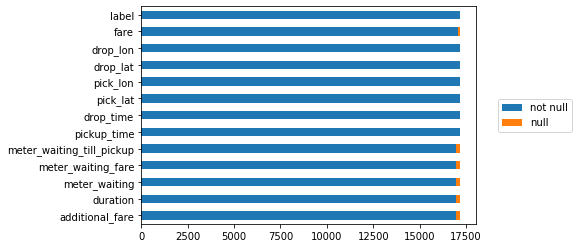

In [3]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

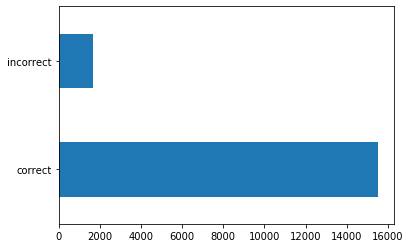

In [4]:
train_df['label'].value_counts().plot.barh()

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler

RANDOM_SEED = 42  

In [6]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [7]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [8]:
labels_df = preprocess_labels(labels_raw_df)

In [20]:
def preprocess_features(input_features_df):
    features_df = input_features_df.copy()
    
    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    #duration
    features_df['duration_fill'] = (features_df['drop_time'] - features_df['pickup_time']).dt.total_seconds()
    features_df['duration'] = features_df['duration'].fillna(features_df['duration_fill'])
    
    features_df = features_df.drop(columns=['duration_fill'])

    #travel time
    features_df['travel_time'] = features_df['duration'] - features_df['meter_waiting']
    
    #waiting time
    features_df['waiting_time'] = features_df['meter_waiting'] + features_df['meter_waiting_till_pickup']
    
    #distance fare
    features_df['distance_fare'] = features_df['fare'] - features_df['meter_waiting_fare'] - features_df['additional_fare']
   
    #distance
    features_df['manhattan_distance'] = abs(features_df['drop_lat'] - features_df['pick_lat']) + abs(features_df['drop_lon'] - features_df['pick_lon'])

    #get day of the week
    #features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    #features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
    features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

    
    #encode cyclic 24 hours with sin and cos
    features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
    features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

    features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
    features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)
    
    #features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time', 'pickup_hour_float', 'drop_hour_float'])
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])
    
    return features_df

In [21]:
features_df = preprocess_features(features_raw_df)

In [22]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [23]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt


RANDOM_SEED = 4
thresh = 5

In [24]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [25]:
rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=11,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)

rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
#Imputer Simple Mean
y_pred = rf.predict(x_eval)
from sklearn.metrics import fbeta_score

print(f'F1 score: {f1_score(y_eval, y_pred)}')
print(f'F1 score: {f1_score(y_eval, y_pred, average="macro")}')

F1 score: 0.9728434504792332
F1 score: 0.8475328363507277


In [27]:
test_pred = rf.predict(test_features_df)

In [28]:
submission_df = pd.read_csv('../sample_submission.csv',index_col="tripid")

np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
    
submission_df["prediction"] = test_pred

submission_df.to_csv('../submission_test1.csv', index=True)

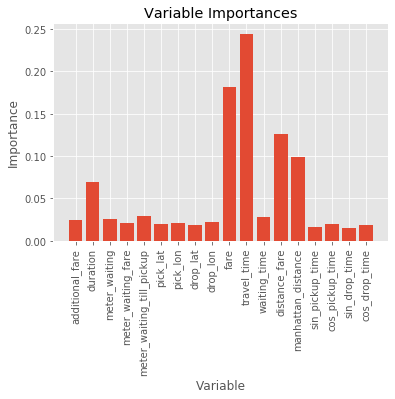

In [29]:
feature_list = list(features_df.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
# Set the style
plt.style.use('ggplot')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [30]:
s1 = pd.read_csv('../submission1.csv',index_col="tripid") #NN 2
s2 = pd.read_csv('../submission2.csv',index_col="tripid") #RF 4
snn = pd.read_csv('../submission_nn.csv',index_col="tripid") #NN 1
s4 = pd.read_csv('../submission_4.csv',index_col="tripid") #XGB 5
s5 = pd.read_csv('../submission5.csv',index_col="tripid") #XGB 3
s8 = pd.read_csv('../submission8.csv',index_col="tripid") #XGB 6

s10 = pd.read_csv('../submission10.csv',index_col="tripid") #XGB 

st1 = pd.read_csv('../submission_test1.csv',index_col="tripid") #RF
st2 = pd.read_csv('../submission_test2.csv',index_col="tripid") #RF


print('\nXGB : NN')
print(abs(s10['prediction'] - snn['prediction']).sum())
print()

print(abs(s1['prediction'] - snn['prediction']).sum())
print(abs(s1['prediction'] - s10['prediction']).sum())
print()

print(abs(s5['prediction'] - snn['prediction']).sum())
print(abs(s5['prediction'] - s10['prediction']).sum())

print()


print(abs(st1['prediction'] - snn['prediction']).sum())
print(abs(st2['prediction'] - snn['prediction']).sum())
print()

print(abs(st1['prediction'] - s10['prediction']).sum())
print(abs(st2['prediction'] - s10['prediction']).sum())
print()



XGB : NN
221

206
253

290
181

295
277

172
148

